Project code name "Ignition" is about scaling some [PySpark](http://spark.apache.org/) computation for timeseries processing on [Amazon AWS](https://aws.amazon.com). The target is to process 1TB of timeseries on different hardware setups and extract metrics like execution time or AWS related costs. This first part introduces the context: the data and the computation that will be the subject of this experiment. The following parts will cover the performance, scalability and cost on AWS.

Regarding the data, here is an interesting dataset: [The MIMIC-III Waveform Database Matched Subset](https://physionet.org/physiobank/database/mimic3wdb/matched/).

This dataset contains thousands of [ECG recordings](https://en.wikipedia.org/wiki/Electrocardiography) which consist in hear beat signals with a rate of 125 samples per second. As the data comes in a specific format called [WFDB](https://physionet.org/physiotools/wfdb.shtml), WFDB files were converted to [Parquet](https://parquet.apache.org/) file format.

In this first part, PySpark will be used to distribute the computation on a local Spark Standalone installation.

Now lets go through the interesting bits of the code.

In [1]:
RATE = 16

In [2]:
import sys
sys.version

'3.6.4 | packaged by conda-forge | (default, Dec 23 2017, 16:31:06) \n[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]'

In [3]:
import datetime

In [4]:
tstart = datetime.datetime.now()
print(tstart.isoformat())

2018-04-08T19:52:40.772133


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

import pandas as pd
print(pd.__version__)
print(pd.__path__)
pd.set_option('display.max_colwidth', -1)

import pyarrow
print(pyarrow.__version__)
print(pyarrow.__path__)

import pyspark
import pyspark.sql
print(pyspark.__version__)
print(pyspark.__path__)

0.22.0
['/opt/conda/lib/python3.6/site-packages/pandas']
0.9.0
['/opt/conda/lib/python3.6/site-packages/pyarrow']
2.3.0
['/usr/local/spark/python/pyspark']


_**Initialise the Spark session in order to use the Spark SQL DataFrame API.**_

In [6]:
%%time

spark = pyspark.sql                 \
               .SparkSession        \
               .builder             \
               .appName('ignition') \
               .getOrCreate()

CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 1.78 s


_**Load the list of parquet files composing the dataset.**_

In [7]:
sdf = spark.read \
           .csv('parquet_files.csv',
                header=True,
                inferSchema=True)
sdf.limit(10).toPandas()

,file,size,bucket_id,subject_id,record_id
0,../../data/physionet/mimic3wdb/matched/p00/p003495/3916659.0000.parquet,89215291,p00,p003495,p00-p003495-3916659
1,../../data/physionet/mimic3wdb/matched/p00/p003495/3916659.0001.parquet,16368810,p00,p003495,p00-p003495-3916659
2,../../data/physionet/mimic3wdb/matched/p00/p000020/3544749.0000.parquet,68988192,p00,p000020,p00-p000020-3544749
3,../../data/physionet/mimic3wdb/matched/p00/p000020/3544749.0001.parquet,69456632,p00,p000020,p00-p000020-3544749
4,../../data/physionet/mimic3wdb/matched/p00/p000020/3544749.0002.parquet,70660667,p00,p000020,p00-p000020-3544749
5,../../data/physionet/mimic3wdb/matched/p00/p000020/3544749.0003.parquet,30201955,p00,p000020,p00-p000020-3544749
6,../../data/physionet/mimic3wdb/matched/p00/p000030/3524877.0000.parquet,7733673,p00,p000030,p00-p000030-3524877
7,../../data/physionet/mimic3wdb/matched/p00/p000033/3713820.0000.parquet,74591347,p00,p000033,p00-p000033-3713820
8,../../data/physionet/mimic3wdb/matched/p00/p000033/3713820.0001.parquet,75399674,p00,p000033,p00-p000033-3713820
9,../../data/physionet/mimic3wdb/matched/p00/p000033/3713820.0002.parquet,1863999,p00,p000033,p00-p000033-3713820


During the conversion of WFDB files to Parquet, the signal has been splitted in dataframe of 10 millions rows which produces Parquet files averaging 70MB in size.

_**Take one row and print the Parquet file size.**_

In [8]:
row = list(
    map(lambda row: (row.record_id, 
                     row.file, 
                     row.size), 
        sdf.select('record_id', 
                   'file', 
                   'size') \
           .take(1)))[0]
record_id, parquet_file, size = row

print('Parquet files size: %d bytes' % size)

Parquet files size: 89215291 bytes


_**Read the parquet file with Pandas (using [Apache Arrow](https://arrow.apache.org)).**_

In [9]:
%%time

pdf = pd.read_parquet(parquet_file)

print('Number of rows: %d' % len(pdf))
print('Memory usage: %d bytes' % pdf.memory_usage().sum())

Number of rows: 10000000
Memory usage: 400000000 bytes
CPU times: user 1.45 s, sys: 456 ms, total: 1.9 s
Wall time: 1.84 s


Without Parquet data compression, the size of one block of data in memory is 400MB.

In [10]:
pdf.head()

,time,record,parameter,value
0,2205-05-12 14:21:31.960,3916659_0001,II,0.000000
1,2205-05-12 14:21:32.016,3916659_0001,II,-0.398438
2,2205-05-12 14:21:32.024,3916659_0001,II,-0.453125
3,2205-05-12 14:21:32.032,3916659_0001,II,1.500000
4,2205-05-12 14:21:32.040,3916659_0001,II,1.500000


(Don't be afraid by the year 2205 in the time column, it is coming as is from the original WFDB file.)

_**Pivot data to tranform the dataset from narrow format to wide format** (but because there is only one parameter "II" in this dataset, I will get only one column named "II")_

In [11]:
%%time

pdf = pdf.pivot(index='time',
                columns='parameter',
                values='value')
pdf.sort_index(inplace=True)

print('Number of rows: %d' % len(pdf))
print('Memory usage: %d bytes' % pdf.memory_usage().sum())

Number of rows: 10000000
Memory usage: 160000000 bytes
CPU times: user 3.51 s, sys: 896 ms, total: 4.41 s
Wall time: 4.41 s


While removing columns "record" and "parameter" the pivot is reducing the size of the data to 160MB.

In [12]:
pdf.head()

parameter,II
time,
2205-05-12 05:06:01.000,-0.007812
2205-05-12 05:06:01.008,-0.007812
2205-05-12 05:06:01.016,0.000000
2205-05-12 05:06:01.024,-0.007812
2205-05-12 05:06:01.032,0.007812


_**Plot the 10 first seconds of signal** (and fortunately it looks like heart beats !)_

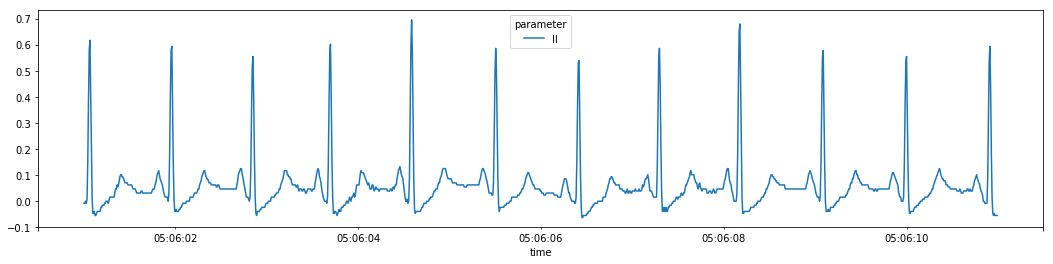

In [13]:
pdf[:125*10].plot(figsize=(18, 4))
plt.show()

_**Clean and down sample the data (from 125Hz to 16Hz)**_

In [14]:
raw_pdf = pdf

# RATE = 16

pdf = pdf.fillna(method='ffill')
pdf = pdf.resample(
    '%dus' % int(1000000 / RATE)
).mean()

print('Number of rows: %d' % len(pdf))
print('Memory usage: %d bytes' % pdf.memory_usage().sum())
pdf.head()

Number of rows: 1382384
Memory usage: 22118144 bytes


parameter,II
time,
2205-05-12 05:06:01.000000,0.136719
2205-05-12 05:06:01.062500,0.126953
2205-05-12 05:06:01.125000,-0.040039
2205-05-12 05:06:01.187500,-0.010742
2205-05-12 05:06:01.250000,0.008789


After down sampling, the number of rows that will be processed is reduced to around 1 million and the size of the data is down to 22MB.

_**Plot the down sampled signal**_

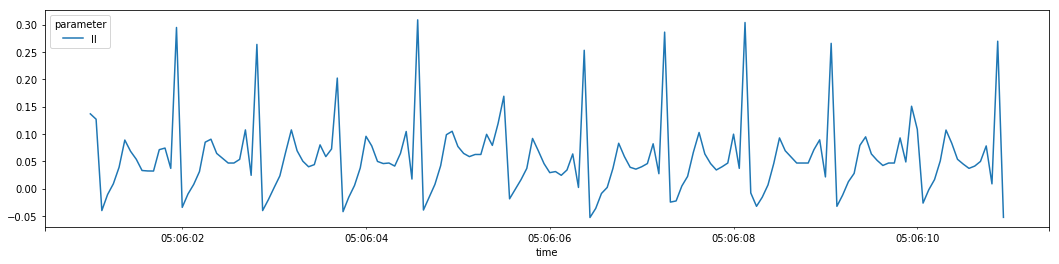

In [15]:
pdf[:RATE*10].plot(figsize=(18, 4))
plt.show()

The down sampled signal shows less noise but the peak's amplitude has been affected too (around 0.30 when it was 0.60 in the raw signal)

_**Here is the computation that will be applied on the signal**_

In [16]:
def extract_features(pdf):
    result_pdf = None
    for column in pdf.columns:
        
        local_mins = argrelextrema(
            pdf[column].values, np.less
        )[0]
        
        local_maxs = argrelextrema(
            pdf[column].values, np.greater
        )[0]
        
        local_minmaxs = np.sort(
            np.concatenate((local_mins, local_maxs))
        )
        
        if result_pdf is None:
            result_pdf = pd.DataFrame()
            result_pdf[column] = pdf[column][local_minmaxs]
        else:
            tmp_pdf = pd.DataFrame()
            tmp_pdf[column] = pdf[column][local_minmaxs]
            result_pdf = pd.merge(result_pdf, 
                                  tmp_pdf, 
                                  left_index=True, 
                                  right_index=True, 
                                  how='outer' )
    return result_pdf

The Scipy function argrelextrema() is used to extract relative extrema (local minimums and maximums) of the down sampled signal. I choose this function for the only reason it needs to scan the signal in full while keeping the computation light (the purpose of this whole exercise is to focus on the IO-boundness of the problem ^^).

_**Apply the computation**_

In [17]:
%%time

result_pdf = extract_features(pdf)

print('Number of rows: %d' % len(result_pdf))
print('Memory usage: %d bytes' % result_pdf.memory_usage().sum())

/opt/conda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/opt/conda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
/opt/conda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/opt/conda/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


Number of rows: 610660
Memory usage: 9770560 bytes
CPU times: user 1.22 s, sys: 20 ms, total: 1.24 s
Wall time: 1.24 s


The resulting data is now about 600000 rows and 10MB.

In [18]:
result_pdf.head()

,II
time,
2205-05-12 05:06:01.125000,-0.040039
2205-05-12 05:06:01.375000,0.088867
2205-05-12 05:06:01.687500,0.032227
2205-05-12 05:06:01.812500,0.074219
2205-05-12 05:06:01.875000,0.037109


_**Plot results on the down sampled signal**_

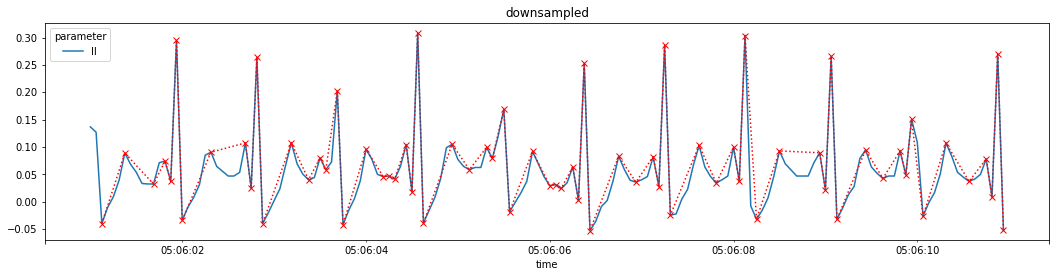

In [19]:
plt.figure(figsize=(18, 4))

ax = plt.subplot('111')
pdf[:RATE*10].plot(ax=ax)
result_pdf[:pdf.index[RATE*10]].plot(
    ax=ax, 
    title='downsampled', 
    color='r', 
    style=':', 
    marker='x', 
    legend=False
)

plt.show()

At first sight, the detected relative extrema (coupled with linear interpolation) look like a good signal approximation but it is not defect free:
![DEFECTS](/assets/img/2018-04-03-ignition-part1_30_0_annotated.png)

_**Plot results over the original signal**_

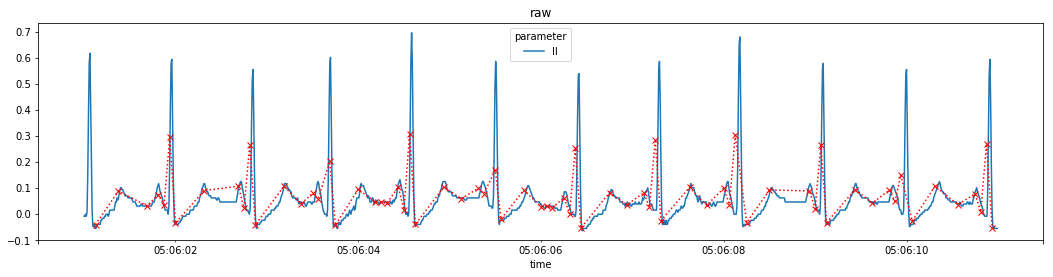

In [20]:
plt.figure(figsize=(18, 4))

ax = plt.subplot('111')
raw_pdf[:125*10].plot(ax=ax)
result_pdf[:pdf.index[RATE*10]].plot(
    ax=ax, 
    title='raw', 
    color='r', 
    style=':', 
    marker='x', 
    legend=False
)

plt.show()

Compared to the raw signal, the approximation looks even worse given that we miss all maximum peaks.

In [21]:
tend = datetime.datetime.now()
print(tend.isoformat())
print('%fs elapsed' % (tend-tstart).total_seconds())

2018-04-08T19:53:21.926583
41.154450s elapsed


So here is the context. We will process heart beat signals by blocks of 10 millions samples to detect local extrema. And we will do that on 1TB of data.

To give you an idea, it takes around 40 seconds to process the example of signal of this blog post on one core of an Intel Core i7-6700K CPU. Using the 8 cores of the same CPU with 32GB of memory, it takes around 14 hours to process the full dataset (which total size is just under 1.2TB).

In Part II we will see how to distribute this significant piece of processing on AWS using EC2 and S3.